In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from gensim.models import Word2Vec

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [6]:
from six import StringIO

In [3]:
pip install six

Note: you may need to restart the kernel to use updated packages.


In [7]:
from IPython.display import Image

In [8]:
from sklearn.tree import export_graphviz

In [10]:
pip install pydotplus

  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp37-none-any.whl size=24573 sha256=b4ba2aa1bd305790782b8308788b457c41a1c121a98588ee84c3b96c83b79caa
  Stored in directory: C:\Users\hp\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [8]:
con = sqlite3.connect('database.sqlite')

In [9]:
filtered_data=pd.read_sql_query("""Select * FROM Reviews WHERE Score !=3 LIMIT 5000 """,con)

In [10]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [11]:
def partition(x):
    if x<3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [12]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (5000, 10)


In [14]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort', na_position='last')

In [15]:
type(sorted_data)

pandas.core.frame.DataFrame

In [16]:
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace = False)

In [17]:
len(final)

4986

In [18]:
display = pd.read_sql_query("""Select * From Reviews Where Score!=3 and HelpfulnessNumerator > HelpfulnessDenominator""",con)

In [19]:
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [20]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [21]:
print(final.shape)

(4986, 10)


In [22]:
sent_0 = final['Text'].values[0]
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [23]:
#Removing html tags

In [24]:
import re
sent_0 = re.sub(r"http\S+", "", sent_0)

In [25]:
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [26]:
soup = BeautifulSoup(sent_0, 'lxml')

In [27]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [29]:
from tqdm import tqdm

preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1583.97it/s]


In [30]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [31]:
len(preprocessed_reviews)

4986

In [32]:
type(preprocessed_reviews)

list

In [33]:
filtered_data.shape

(5000, 10)

In [34]:
# Adding preprocessed text to the original dataframe

In [35]:
final['preprocessed reviews'] = preprocessed_reviews

In [36]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed reviews
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...


## Applying Train test split

In [37]:
X = final['preprocessed reviews']
Y = final['Score']

In [38]:
print(X.shape,Y.shape)

(4986,) (4986,)


In [39]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [48]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(3490,) (1496,) (3490,) (1496,)


### 1. Bag of Words - Unigrams

In [41]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(X_train)
x_test_uni = bow.transform(X_test)

### Multinomial Naive Bayes

### GridSearch to find optimal value of alpha

In [46]:
from sklearn.model_selection import GridSearchCV

In [59]:
NB = MultinomialNB()

alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_uni,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best HyperParameter:  {'alpha': 1}
0.8679083094555875


In [50]:
df = pd.DataFrame(gsv.cv_results_)

In [51]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007007,0.001672,0.002992,0.000904,1000,{'alpha': 1000},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,11
1,0.007000,0.000020,0.003401,0.000490,500,{'alpha': 500},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,11
2,0.005205,0.001165,0.002600,0.000489,100,{'alpha': 100},0.840974,0.842407,0.842407,0.842407,0.842407,0.842120,0.000573,14
3,0.004485,0.000607,0.002599,0.000480,50,{'alpha': 50},0.840974,0.842407,0.842407,0.842407,0.842407,0.842120,0.000573,14
4,0.005600,0.000801,0.003206,0.000399,10,{'alpha': 10},0.840974,0.842407,0.843840,0.842407,0.842407,0.842407,0.000906,11
5,0.006196,0.000397,0.003596,0.001203,5,{'alpha': 5},0.842407,0.843840,0.848138,0.845272,0.843840,0.844699,0.001943,10
6,0.005800,0.001153,0.002603,0.000504,1,{'alpha': 1},0.858166,0.856734,0.876791,0.878223,0.869628,0.867908,0.009034,1
7,0.005202,0.000384,0.002599,0.000798,0.5,{'alpha': 0.5},0.861032,0.851003,0.873926,0.871060,0.871060,0.865616,0.008519,2
8,0.004410,0.000483,0.003178,0.000746,0.1,{'alpha': 0.1},0.853868,0.859599,0.872493,0.866762,0.859599,0.862464,0.006471,5
9,0.004611,0.000488,0.002778,0.000742,0.05,{'alpha': 0.05},0.851003,0.863897,0.862464,0.863897,0.863897,0.861032,0.005045,6


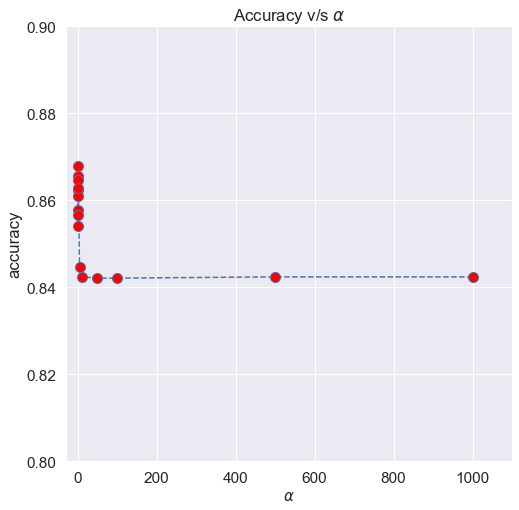

In [52]:
x= df['param_alpha']
y= df['mean_test_score']

plt.figure(figsize=(8,8))
plt.xlim(-30,1100)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### Finding the F1 Score of Test data using optimal alpha

Accuracy on test set: 87.032%
Precision on test set: 0.834
Recall on test set: 0.659
F1-Score on test set: 0.699


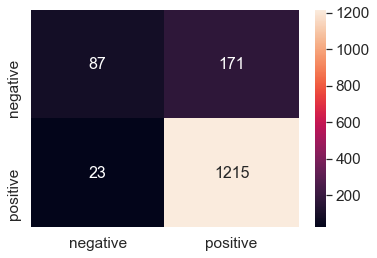

In [71]:
NB = MultinomialNB(1)   # Taking alpha = 1 
NB.fit(x_tr_uni,Y_train)

y_pred = NB.predict(x_test_uni)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred),index = class_label, columns = class_label)

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### 2. Bag of Words - Bigrams

In [72]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(X_train)
x_test_bi = bi_gram.transform(X_test)

### GridSearch to find optimal value of alpha

In [73]:
NB = MultinomialNB()

alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_bi,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best HyperParameter:  {'alpha': 1}
0.8710601719197708


In [74]:
df = pd.DataFrame(gsv.cv_results_)

In [75]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018200,0.002992,0.005004,0.000632,1000,{'alpha': 1000},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,3
1,0.015393,0.001859,0.005001,0.001095,500,{'alpha': 500},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,3
2,0.020008,0.003264,0.004793,0.000753,100,{'alpha': 100},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,3
3,0.017407,0.002503,0.005006,0.000632,50,{'alpha': 50},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,3
4,0.016600,0.001204,0.005593,0.000488,10,{'alpha': 10},0.840974,0.842407,0.842407,0.842407,0.842407,0.842120,0.000573,8
5,0.015221,0.000987,0.004585,0.000490,5,{'alpha': 5},0.840974,0.842407,0.843840,0.842407,0.842407,0.842407,0.000906,3
6,0.014593,0.000798,0.004406,0.000484,1,{'alpha': 1},0.859599,0.871060,0.873926,0.868195,0.882521,0.871060,0.007472,1
7,0.013800,0.000400,0.004400,0.000488,0.5,{'alpha': 0.5},0.812321,0.802292,0.805158,0.812321,0.790831,0.804585,0.007930,11
8,0.015390,0.002058,0.005787,0.001179,0.1,{'alpha': 0.1},0.581662,0.573066,0.578797,0.577364,0.551576,0.572493,0.010820,15
9,0.022598,0.002879,0.007200,0.001327,0.05,{'alpha': 0.05},0.598854,0.584527,0.597421,0.585960,0.551576,0.583668,0.017063,14


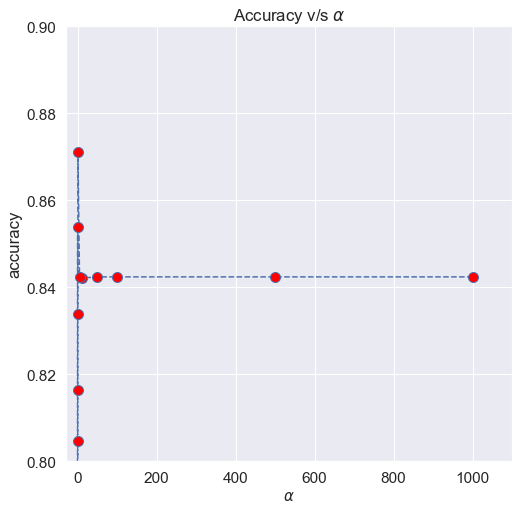

In [76]:
x= df['param_alpha']
y= df['mean_test_score']

plt.figure(figsize=(8,8))
plt.xlim(-30,1100)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### Finding the F1 Score of Test data using optimal alpha

Accuracy on test set: 87.032%
Precision on test set: 0.834
Recall on test set: 0.659
F1-Score on test set: 0.699


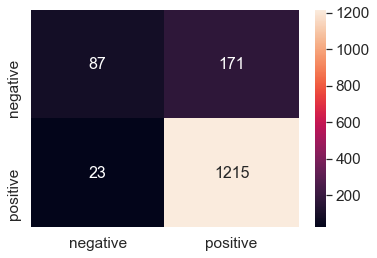

In [77]:
NB = MultinomialNB(1)   # Taking alpha = 1 
NB.fit(x_tr_uni,Y_train)

y_pred = NB.predict(x_test_uni)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred),index = class_label, columns = class_label)

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### 3. TF-IDF

In [107]:
tf_idf_vect  = TfidfVectorizer()
x_tr_tfidf   = tf_idf_vect.fit_transform(X_train)
x_test_tfidf = tf_idf_vect.transform(X_test)

### GridSearch to find optimal value of alpha

In [108]:
NB = MultinomialNB()

alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_tfidf,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best HyperParameter:  {'alpha': 0.01}
0.8650429799426934


In [109]:
df = pd.DataFrame(gsv.cv_results_)

In [110]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006999,0.000893,0.002400,0.000491,1000,{'alpha': 1000},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,8
1,0.007809,0.001331,0.004000,0.000635,500,{'alpha': 500},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,8
2,0.004801,0.000400,0.002399,0.000491,100,{'alpha': 100},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,8
3,0.005001,0.000632,0.002200,0.000401,50,{'alpha': 50},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,8
4,0.006199,0.001166,0.003202,0.000750,10,{'alpha': 10},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,8
5,0.004999,0.000004,0.003200,0.000399,5,{'alpha': 5},0.842407,0.842407,0.842407,0.842407,0.842407,0.842407,0.000000,8
6,0.005396,0.000791,0.002603,0.000494,1,{'alpha': 1},0.840974,0.842407,0.842407,0.842407,0.842407,0.842120,0.000573,15
7,0.006201,0.000979,0.003402,0.001016,0.5,{'alpha': 0.5},0.842407,0.842407,0.843840,0.840974,0.842407,0.842407,0.000906,8
8,0.006797,0.001469,0.003801,0.001166,0.1,{'alpha': 0.1},0.848138,0.849570,0.865330,0.866762,0.869628,0.859885,0.009124,4
9,0.005404,0.000490,0.002997,0.000636,0.05,{'alpha': 0.05},0.855301,0.856734,0.872493,0.869628,0.865330,0.863897,0.006841,2


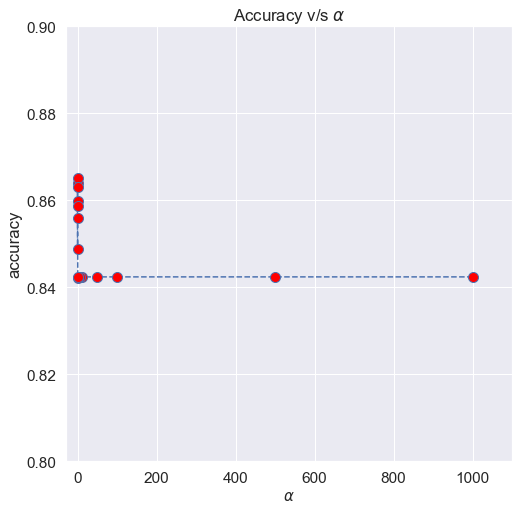

In [111]:
x= df['param_alpha']
y= df['mean_test_score']

plt.figure(figsize=(8,8))
plt.xlim(-30,1100)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### Finding the F1 Score of Test data using optimal alpha

Accuracy on test set: 86.765%
Precision on test set: 0.791
Recall on test set: 0.688
F1-Score on test set: 0.721


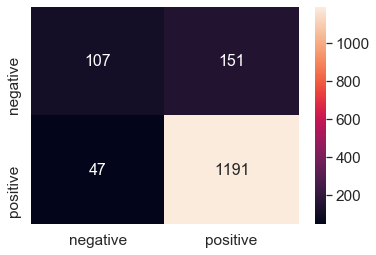

In [113]:
NB = MultinomialNB(0.01)
NB.fit(x_tr_uni,Y_train)

y_pred = NB.predict(x_test_uni)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred),index = class_label, columns = class_label)

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [84]:
from prettytable import PrettyTable

In [114]:
z = PrettyTable()
z.field_names = ["Model","Optimal hyper parameter","F1score test","accuracy Test"]
z.add_row(["Unigram",1,0.699,87.032])
z.add_row(["Bigram",1,0.699,87.032])
z.add_row(["Tfidf",0.01,0.721,86.765])
print(z)

+---------+-------------------------+--------------+---------------+
|  Model  | Optimal hyper parameter | F1score test | accuracy Test |
+---------+-------------------------+--------------+---------------+
| Unigram |            1            |    0.699     |     87.032    |
|  Bigram |            1            |    0.699     |     87.032    |
|  Tfidf  |           0.01          |    0.721     |     86.765    |
+---------+-------------------------+--------------+---------------+
